In [5]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import parselmouth
from scipy.signal import find_peaks
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
path1=r"C:\Users\Pak\Downloads\truncated-train-contents"
path2=r"C:\Users\Pak\Downloads\cv-valid-test-contents"


In [21]:
def access_folder_contents(folder_path):
    files = []
    for root, dirs, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    return files
files_in_path1 = access_folder_contents(path1)
files_in_path2 = access_folder_contents(path2)

#print("Files in path 1:")
#for file_path in files_in_path1:
    #print(file_path)
#print("\nFiles in path 2:")
#for file_path in files_in_path2:
    #print(file_path)

In [14]:
type(files_in_path2)

list

In [41]:
def split_list_into_parts(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i*k + min(i, m):(i+1)*k + min(i+1, m)] for i in range(n)]
parts = split_list_into_parts(files_in_path1, 4)

In [44]:
def split_list_into_parts(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i*k + min(i, m):(i+1)*k + min(i+1, m)] for i in range(n)]
parts2 = split_list_into_parts(files_in_path2, 5)

In [42]:
print(len(parts[0]))
print(len(parts[1]))
print(len(parts[2]))
print(len(parts[3]))

3751
3751
3751
3751


In [45]:
print(len(parts2[0]))
print(len(parts2[1]))
print(len(parts2[2]))
print(len(parts2[3]))
print(len(parts2[4]))

799
799
799
799
799


In [46]:
import librosa
import numpy as np

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio at its native sampling rate
    features = {}

    # Pitch (fundamental frequency)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    valid_pitches = pitches[magnitudes > np.median(magnitudes)]
    if valid_pitches.size > 0:
        pitch = valid_pitches.mean()
    else:
        pitch = 0  # Handle case with no valid pitches
    features['pitch'] = pitch

    # Formant frequencies using LPC
    lpc_coeff = librosa.lpc(y, order=2)
    features['lpc_coeff'] = lpc_coeff  # Storing LPC coefficients directly

    # Intensity (energy)
    intensity = librosa.feature.rms(y=y).mean()
    features['intensity'] = intensity

    # Duration
    features['duration'] = librosa.get_duration(y=y, sr=sr)

    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    features['spectral_centroid'] = spectral_centroids

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    features['spectral_rolloff'] = spectral_rolloff

    return features

def process_audio_files(file_list):
    return [extract_features(file) for file in file_list]

# Assuming files_in_path1 is the cv-valid-test-contents 799 slicing
features_from_path1 = process_audio_files(parts[0])

In [56]:
features_from_path12 = process_audio_files(parts[1])

In [57]:
features_from_path13 = process_audio_files(parts[2])

In [58]:
features_from_path14 = process_audio_files(parts[3])

In [51]:
features_from_path21 = process_audio_files(parts[0])

In [52]:
features_from_path22 = process_audio_files(parts2[1])

In [53]:
features_from_path23 = process_audio_files(parts2[2])

In [54]:
features_from_path24 = process_audio_files(parts2[3])

In [55]:
features_from_path25 = process_audio_files(parts2[4])

In [67]:
df1=pd.DataFrame(features_from_path1)
df2=pd.DataFrame(features_from_path12)
df3=pd.DataFrame(features_from_path13)
df4=pd.DataFrame(features_from_path14)

In [108]:
result_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
#print(result_df.head(5))
#print(result_df.info)

In [94]:
len(features_from_path21)

3751

In [98]:
df21=pd.DataFrame(features_from_path21)
df25=pd.DataFrame(features_from_path25)

In [104]:
#df25.info

In [105]:
df25=df25[555:]

In [107]:
result_df2 = pd.concat([df21,df25], ignore_index=True)
#print(result_df2.head(5))
#print(result_df2.info)

In [109]:
result_df.to_csv('features_cvtc.csv', index=False)
result_df2.to_csv('features_ttc.csv', index=False)

In [ ]:
#"C:\Users\Pak\features_cvtc.csv"
#"C:\Users\Pak\features_ttc.csv"

# Step2

In [6]:
df1 = pd.read_csv(r"C:\Users\Pak\features_cvtc.csv")
df2 = pd.read_csv(r"C:\Users\Pak\features_ttc.csv") 
missing_values_df1 = df1.isnull().sum()
missing_values_df2 = df2.isnull().sum()
print(missing_values_df1)
print(missing_values_df2)

pitch                0
lpc_coeff            0
intensity            0
duration             0
spectral_centroid    0
spectral_rolloff     0
dtype: int64
pitch                0
lpc_coeff            0
intensity            0
duration             0
spectral_centroid    0
spectral_rolloff     0
dtype: int64


In [7]:
# Mean Imputation
#no missing values
#df1.fillna(df1.mean(), inplace=True)
#df2.fillna(df2.mean(), inplace=True)

In [8]:
df1.columns

Index(['pitch', 'lpc_coeff', 'intensity', 'duration', 'spectral_centroid',
       'spectral_rolloff'],
      dtype='object')

In [9]:
#df1['lpc_coeff'] = df1['lpc_coeff'].apply(lambda x: ','.join(x.split()))
#df1['lpc_coeff'] = df1['lpc_coeff'].apply(lambda x: ' '.join(x.lstrip(',').split()))
#df2['lpc_coeff'] = df2['lpc_coeff'].apply(lambda x: ','.join(x.split()))

In [10]:
df1['lpc_coeff'] = df1['lpc_coeff'].apply(lambda x: x.strip('[]').split())

In [11]:
df1['lpc_coeff'].head(5)

0     [1., -1.9083494, 0.9153367]
1     [1., -1.8787999, 0.8992487]
2       [1., -1.9056594, 0.90771]
3     [1., -1.9060233, 0.9219292]
4    [1., -1.3687449, 0.41513205]
Name: lpc_coeff, dtype: object

In [12]:
expanded_df1 = pd.DataFrame(df1["lpc_coeff"].tolist(), columns=["lpc_coeff1","lpc_coeff2","lpc_coeff3"])

In [13]:
expanded_df1.head(3)

,lpc_coeff1,lpc_coeff2,lpc_coeff3
0,1.,-1.9083494,0.9153367
1,1.,-1.8787999,0.8992487
2,1.,-1.9056594,0.90771


In [14]:
df2['lpc_coeff'] = df2['lpc_coeff'].apply(lambda x: x.strip('[]').split())
expanded_df2 = pd.DataFrame(df2["lpc_coeff"].tolist(), columns=["lpc_coeff1","lpc_coeff2","lpc_coeff3"])

In [15]:
df1 = pd.concat([expanded_df1, df1], axis=1)
df1= df1.drop('lpc_coeff', axis=1)

In [16]:
df2 = pd.concat([expanded_df2, df2], axis=1)
df2= df2.drop('lpc_coeff', axis=1)

In [17]:
df1.head(5)

,lpc_coeff1,lpc_coeff2,lpc_coeff3,pitch,intensity,duration,spectral_centroid,spectral_rolloff
0,1.,-1.9083494,0.9153367,1473.41360,0.010486,2.496,1560.430376,3142.121011
1,1.,-1.8787999,0.8992487,1551.78920,0.097466,7.056,1795.988452,3044.538331
2,1.,-1.9056594,0.90771,460.42413,0.009001,3.576,3248.940561,6612.792969
3,1.,-1.9060233,0.9219292,1814.97300,0.044882,5.904,1976.429247,3604.805957
4,1.,-1.3687449,0.41513205,1584.14840,0.070931,6.576,3890.960154,6748.252634


In [18]:
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
df1_scaled = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)
# Apply the same transformation to the testing data
df2_scaled = pd.DataFrame(scaler.transform(df2), columns=df2.columns)


In [19]:
df1_scaled.head(3)

,lpc_coeff1,lpc_coeff2,lpc_coeff3,pitch,intensity,duration,spectral_centroid,spectral_rolloff
0,0.0,-0.825418,0.779798,-0.198494,-0.913254,-0.939370,-1.359087,-1.179708
1,0.0,-0.671592,0.681942,0.077886,1.576797,1.291604,-1.066266,-1.241865
2,0.0,-0.811415,0.733408,-3.770642,-0.955793,-0.410981,0.739896,1.030998


In [20]:
df1.columns

Index(['lpc_coeff1', 'lpc_coeff2', 'lpc_coeff3', 'pitch', 'intensity',
       'duration', 'spectral_centroid', 'spectral_rolloff'],
      dtype='object')

In [21]:
age_df1 = pd.read_excel(r"C:\Users\Pak\Downloads\truncated_train.xlsx")
age_df2 = pd.read_excel(r"C:\Users\Pak\Downloads\cv-valid-test.xlsx")

In [22]:
age_mapping = {
    "teens": 10,
    "twenties": 20,
    "thirties": 30,
    "forties": 40,
    "fifties": 50,
    "sixties": 60,
    "seventies":70,
    "eighties": 80,
    "nineties": 90,
    
    # Add more mappings as needed
}

# Apply the mapping to the 'age' column
age_df1['age'] = age_df1['age'].map(age_mapping)
age_df2['age'] = age_df2['age'].map(age_mapping)

In [23]:
age_df1.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,20.0,female,us,NaN
6,cv-valid-train/sample-000006.mp3,night fell and an assortment of fighting men a...,3,0,NaN,NaN,NaN,NaN
7,cv-valid-train/sample-000007.mp3,i heard a faint movement under my feet,2,1,NaN,NaN,NaN,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,70.0,male,us,NaN
9,cv-valid-train/sample-000009.mp3,when he speaks in our language i can interpret...,1,0,NaN,NaN,NaN,NaN


In [24]:
print("Number of rows in dataframe1:", len(age_df1))
print("Number of rows in dataframe2:", len(age_df2))

Number of rows in dataframe1: 15001
Number of rows in dataframe2: 3995


In [25]:
print("Number of rows in dataframe1:", len(df1_scaled))
print("Number of rows in dataframe2:", len(df2_scaled))

Number of rows in dataframe1: 15004
Number of rows in dataframe2: 3995


In [26]:
print("Missing values in dataframe1:", df1_scaled.isnull().sum())
print("Missing values in dataframe2:", df2_scaled.isnull().sum())

Missing values in dataframe1: lpc_coeff1           0
lpc_coeff2           0
lpc_coeff3           0
pitch                0
intensity            0
duration             0
spectral_centroid    0
spectral_rolloff     0
dtype: int64
Missing values in dataframe2: lpc_coeff1           0
lpc_coeff2           0
lpc_coeff3           0
pitch                0
intensity            0
duration             0
spectral_centroid    0
spectral_rolloff     0
dtype: int64


In [27]:
#age_df1= age_df1.isnull().sum()
#age_df2= age_df2.isnull().sum()

In [28]:
print(type(age_df1))
print(age_df1.head())

<class 'pandas.core.frame.DataFrame'>
                           filename  \
0  cv-valid-train/sample-000000.mp3   
1  cv-valid-train/sample-000001.mp3   
2  cv-valid-train/sample-000002.mp3   
3  cv-valid-train/sample-000003.mp3   
4  cv-valid-train/sample-000004.mp3   

                                                text  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start your emails with greetings let me...         3           2   

   age gender accent  duration  
0  NaN    NaN    NaN       NaN  
1  NaN    NaN    NaN       NaN  
2  NaN    NaN    NaN       NaN  
3  NaN    NaN    NaN       NaN  
4  NaN    NaN    NaN       NaN  


In [29]:
print("Shape of df1_scaled:", df1_scaled.shape)
print("Shape of age_df1:", age_df1.shape)
print("Shape of df1_scaled:", df2_scaled.shape)
print("Shape of age_df1:", age_df2.shape)

Shape of df1_scaled: (15004, 8)
Shape of age_df1: (15001, 8)
Shape of df1_scaled: (3995, 8)
Shape of age_df1: (3995, 8)


In [30]:
df1_scaled.reset_index(drop=True, inplace=True)
age_df1.reset_index(drop=True, inplace=True)
df2_scaled.reset_index(drop=True, inplace=True)
age_df2.reset_index(drop=True, inplace=True)

In [31]:
# Remove rows from 'df1_scaled' to align with 'age_df1'
df1_scaled = df1_scaled.iloc[:15001]

In [32]:
# Example of imputing missing values (mean imputation)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df1_scaled_imputed = imputer.fit_transform(df1_scaled)

In [33]:
# Example of imputing missing values (mean imputation)
from sklearn.impute import SimpleImputer
imputer2 = SimpleImputer(strategy='mean')
df2_scaled_imputed = imputer2.fit_transform(df2_scaled)

In [34]:
# Check for NaN values in 'df1_scaled_imputed'
nan_indices = np.isnan(df1_scaled_imputed)
nan_count = np.sum(nan_indices)

print("Number of NaN values in df1_scaled_imputed:", nan_count)

Number of NaN values in df1_scaled_imputed: 0


In [35]:
# Check for NaN values in 'df1_scaled_imputed'
nan_indices2 = np.isnan(df2_scaled_imputed)
nan_count2 = np.sum(nan_indices2)

print("Number of NaN values in df1_scaled_imputed:", nan_count2)

Number of NaN values in df1_scaled_imputed: 0


In [36]:
print(age_df1.isna().sum())

filename          0
text              0
up_votes          0
down_votes        0
age           10276
gender         9375
accent        10068
duration      15001
dtype: int64


In [37]:
print(age_df2.isna().sum())

filename         0
text             0
up_votes         0
down_votes       0
age           2689
gender        2454
accent        2657
duration      3995
dtype: int64


In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')  # or 'mean'
age_df1['age'] = imputer.fit_transform(age_df1[['age']])

In [39]:
from sklearn.impute import SimpleImputer

imputer2 = SimpleImputer(strategy='median')  # or 'mean'
age_df2['age'] = imputer2.fit_transform(age_df2[['age']])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df1_scaled_imputed,  age_df1['age'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df1_scaled, age_df1['age'], test_size=0.2, random_state=42)
# Create a Neural Network Regression model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
# Train the model using the training data
model.fit(X_train, y_train)
# Make predictions on the testing data
predictions = model.predict(X_test)
# Calculate Mean Squared Error (MSE) as a metric
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 81.72815965189447


In [41]:
X_train, X_test, y_train, y_test = train_test_split(df2_scaled_imputed, age_df2['age'], test_size=0.2, random_state=42)
# Create a Neural Network Regression model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
# Train the model using the training data
model.fit(X_train, y_train)
# Make predictions on the testing data
predictions = model.predict(X_test)
# Calculate Mean Squared Error (MSE) as a metric
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 71.61273236686799


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate model on the testing set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2) coefficient of determination:", r2)

# Assess model performance across different age groups (for example, bins of age ranges)
# Define your age groups and corresponding bins based on your data
bins = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_groups = pd.cut(y_test, bins=bins, labels=False)

# Calculate MSE for each age group
mse_by_age_group = {}
for group in np.unique(age_groups):
    indices = np.where(age_groups == group)[0]
    group_predictions = predictions[indices]
    group_actuals = y_test.iloc[indices]
    mse_by_age_group[group] = mean_squared_error(group_actuals, group_predictions)

# Print MSE for each age group
for group, mse in mse_by_age_group.items():
    print(f"MSE for age group {group}: {mse}")


Mean Squared Error (MSE): 71.61273236686799
Mean Absolute Error (MAE): 4.307784508940849
R-squared (R^2) coefficient of determination: -0.012774195426350499
MSE for age group 0: 418.8371892040679
MSE for age group 1: 103.47249960198103
MSE for age group 2: 2.092889149331233
MSE for age group 4: 382.0823313330328
MSE for age group 5: 873.0011273812752
MSE for age group 6: 1528.727992744877
MSE for age group 7: 2556.2507497666384


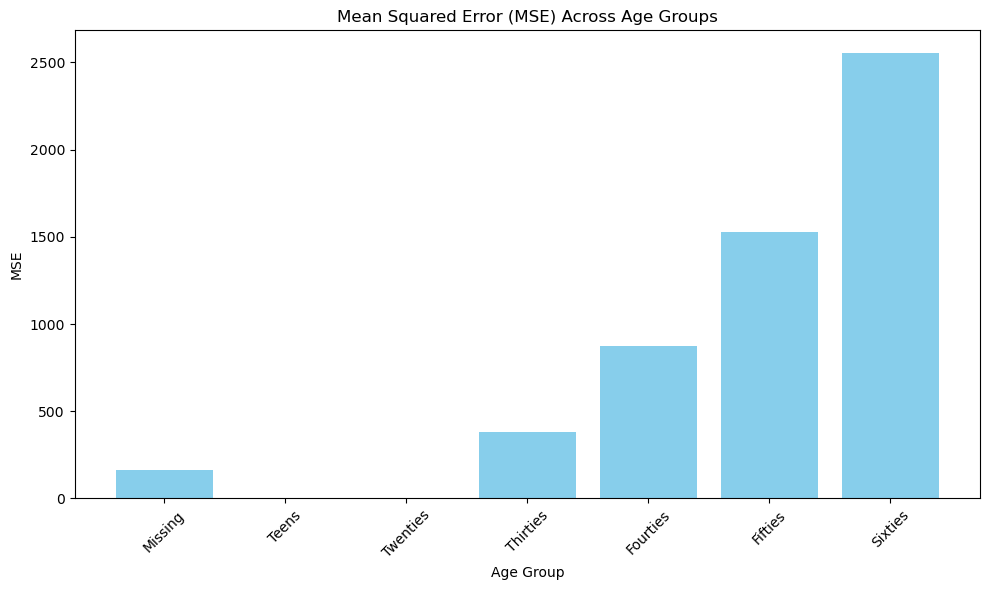

In [43]:
import matplotlib.pyplot as plt

# Define the MSE values and corresponding age groups
mse_values = [164.87093474575016, 2.092889149331233, 0, 382.0823313330328, 873.0011273812752, 1528.727992744877, 2556.2507497666384]
age_groups = ['Missing', 'Teens', 'Twenties', 'Thirties', 'Fourties', 'Fifties', 'Sixties']  # Age group labels (replace with actual labels if available)

# Plot MSE for each age group
plt.figure(figsize=(10, 6))
plt.bar(age_groups, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE) Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
